In [ ]:
# Script to generate the desired spectrum as a lookup table in SystemVerilog
# (C) ETH Zurich 2022
# Group of Prof. Vaterlaus
# Author: Yves Acremann

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import interpolate

## Generate the spectrum

In [2]:
# Coordinates of individual points:
x_set = np.arange(0, 11)*100
y_set = np.zeros_like(x_set)

# Manually create realistic spectrum
y_set[0] = 0
y_set[1] = 0
y_set[2] = 250
y_set[3] = 90
y_set[4] = 20
y_set[5] = 10
y_set[6] = 10
y_set[7] = 40
y_set[8] = 0
y_set[9] = 0
y_set[10] = 0

In [3]:
# interpolate:
interpolator = interpolate.interp1d(x_set,y_set,kind='cubic')
x = np.arange(0, 1000)
y = interpolator(x)
# clip negative numbers:
y[y<0] = 0
# scale max to 1000:
y = y*(1000/y.max())

# set to 0 after 800
y[800:] = 0



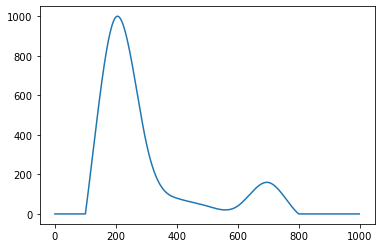

In [4]:
plt.plot(x,y)

## Convert spectrum to "flight times"
(Just by flipping the arrays)

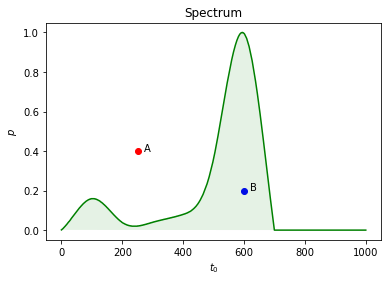

In [5]:
y_flip = np.flip(y)
y_shifted = np.zeros_like(y)
y_shifted[0:1000-200] = y_flip[200:1000]
# convert to int:
y_shifted_int = y_shifted.astype(int)
plt.plot(x, y_shifted_int/1000., color="green")
plt.fill(x, y_shifted_int/1000., facecolor='green', alpha=0.1)

plt.xlabel("$t_0$")
plt.ylabel("$p$")
plt.title("Spectrum")
# mark a point outside the spectrum:
plt.scatter((250), (0.4), color="red")
plt.annotate("A", (250+20,0.4))

# mark a point outside the spectrum:
plt.scatter((600), (0.2), color="blue")
plt.annotate("B", (600+20,0.2))

plt.savefig("plot_idea.pdf")

## Generate SystemVerilog array and store in file LUT.sv

In [6]:
# Syntax of the LUT:
#logic unsigned [9:0] LUT [0:1023] = '{10'd123, 10'd124, ...};
with open("LUT_spectrum.sv","w") as f:
    f.write("// Lookup table holding the desired flight time spectrum \n")
    f.write("// (generated by the Jupyter notebook SpectrumGenerator) \n")
    f.write("// For compatibility with the Xilinx RAM/ROM: The output is registered. \n")
    f.write("module LUT_spectrum(\n    input  logic      clk_i,\n    input  logic[9:0] addr_i,\n    output logic[9:0] data_o\n);\n\n")
    f.write("    logic unsigned [9:0] LUT_spectrum_array [0:1023] = '{\n")
    for i in range(0, 1000):
        f.write("        10'd" + str(y_shifted_int[i]) + ',\n')
    for i in range(1000, 1023):
        f.write("        10'd0,\n")
    f.write("        10'd0\n    };\n\n")
    f.write("    always_ff @(posedge clk_i) begin\n")
    f.write("        data_o <= LUT_spectrum_array[addr_i];\n")
    f.write("    end\n\n")
    f.write("endmodule\n")
    f.close()